In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


In [ ]:
Tinf=[
30.2, 30.53, 30.85, 31.18,
31.5, 32, 32.5, 33,
33, 33.63, 34.25, 34.88,
35.5, 36.25, 37, 37.75,
38, 38.5, 39, 39.5,
40, 40.5, 41, 41.5,
42, 42.5, 43, 43.5,
44, 44.25, 44.5, 44.75,
45, 45.25, 45.5, 45.75,
46, 45.88, 45.75, 45.62,
45.5, 45.25, 45, 44.75,
44.5, 43.88, 43.25, 42.63,
42, 41.5, 41, 40.5,
40, 39.38, 38.75, 38.13,
37.5, 36.88, 36.25, 35.63,
35, 34.5, 34, 33.5,
]
"""Tinf = [
30.0, 30.28, 30.61, 30.98, 31.39, 31.84, 32.32, 32.83,
33.37, 33.93, 34.5, 35.08, 35.65, 36.21, 36.75, 37.25,
37.69, 38.08, 38.4, 38.65, 38.82, 38.9, 38.89, 38.79,
38.59, 38.3, 37.9, 37.4, 36.79, 36.08, 35.27, 34.36,
33.35, 32.25, 31.06, 29.79, 30.0, 30.0, 30.0, 30.0,
30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0,
30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0,
30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0
]"""

Tout=np.array(Tinf)
Tout.size

64

In [ ]:
size=np.array([600,200,100,100,100])
volume=np.array([7500,1500,750,750,750])
ac=np.array([66,22,11,11,11])
tot=sum(ac)
h=30
Cp=1200
qrest=100
tideal=[20,25]
A=np.array([154.49952744,  52.83809514,  33.28591415,  33.28591415,33.28591415])
totol_elec=tot*0.8
ton=3516e



In [ ]:
df=pd.read_csv('/content/Untitled spreadsheet - Sheet1-4.csv')
df=df.drop(columns=['TIme'])
a=df.to_numpy()
a=a.T

In [ ]:
Tout.size

64

In [ ]:
# affective area
# time taken for heating to 95% 45 min
volume=np.array(volume)
A0 = -1*Cp * volume[4] / (h * 60 * 45) * np.log((20 + 15 * 0.95 - 35) / (20 - 35))
A = volume**(2/3) * A0 / (volume[4]**(2/3))
A

array([154.49952744,  52.83809514,  33.28591415,  33.28591415,
        33.28591415])

In [ ]:
A=np.array([154.49952744,  52.83809514,  33.28591415,  33.28591415,33.28591415])

In [ ]:
# aproximate tons required for steady state at 30 C temp diffrence
hout=A*h*(30)
hout=hout+qrest*size
hout/ton

array([56.61250702, 19.21339182, 11.36442626, 11.36442626, 11.36442626])

In [ ]:
pip install gurobipy

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Model
m = gp.Model("HVAC_Optimization")
n_rooms = 5
n_steps = 64
# Variables
L = m.addVars(n_rooms, n_steps, lb=0, ub=GRB.INFINITY,vtype=GRB.INTEGER, name="L")  # HVAC load
O = m.addVars(n_steps, vtype=GRB.BINARY, name="O")                # HVAC on/off
T = m.addVars(n_rooms, n_steps+1 , lb=0, name="T")               # Temperature

# Initial temperature
for i in range(n_rooms):
    m.addConstr(T[i, 0] == Tinf[0])

# Constraints and dynamics
for j in range(n_steps):
    for i in range(n_rooms):
        # Temperature dynamics
        m.addConstr(
            T[i, j + 1] == T[i, j] + (900 / Cp) * (
                (qrest * size[i] * a[i, j] - ton * L[i, j]) / volume[i]
                - (h * A[i] / volume[i]) * (T[i, j] - Tout[j])
            )
        )

        # HVAC load constraints
        m.addConstr(L[i, j] >= 0)
        m.addConstr(L[i, j] <= ac[i] * O[j])

        # Comfort temperature constraints
        m.addConstr(T[i, j] >= a[i, j] * tideal[0])
        m.addConstr(T[i, j] <= tideal[1] + (1 - a[i, j]) * 100)

# Objective function
op_cost = gp.quicksum(O[j] * (totol_elec * 0.33) for j in range(n_steps))
cool_cost = gp.quicksum(L[i, j] * (totol_elec / tot * 0.66)
                        for i in range(n_rooms) for j in range(n_steps))
m.setObjective((op_cost + cool_cost) / 4, GRB.MINIMIZE)

# Solve
m.setParam('OutputFlag', 0)
m.optimize()

In [ ]:
solution = {var.VarName: var.X for var in m.getVars()}
T_array = np.array([[solution[f"T[{i},{j}]"] for j in range(n_steps + 1)] for i in range(n_rooms)])
L_array = np.array([[solution[f"L[{i},{j}]"] for j in range(n_steps)] for i in range(n_rooms)])
O_array = np.array([solution[f"O[{j}]"] for j in range(n_steps)])

In [ ]:
T_df=pd.DataFrame(T_array.T)
T_df

,0,1,2,3,4
0,30.200000,30.200000,30.200000,30.200000,30.200000
1,30.200000,30.200000,30.200000,30.200000,30.200000
2,30.352955,30.461549,30.529531,30.529531,30.529531
3,30.583334,30.769424,30.849544,30.849544,30.849544
4,30.859888,31.094835,31.179530,31.179530,31.179530
...,...,...,...,...,...
60,36.008836,23.990917,24.514067,24.514067,24.514067
61,35.541242,23.378402,23.889083,23.889083,23.889083
62,35.058628,42.193063,44.484905,44.484905,44.484905
63,34.567955,35.699475,34.014916,34.014916,34.014916


In [ ]:
O_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [ ]:
L_df=pd.DataFrame(L_array.T)
L_df

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
59,0.0,11.0,6.0,6.0,6.0
60,0.0,11.0,6.0,6.0,6.0
61,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Reconstruct from solution dictionary
total_kWh = 0.0
for j in range(n_steps):
    Oj = solution[f"O[{j}]"]
    sum_Lij = sum(solution[f"L[{i},{j}]"] for i in range(n_rooms))
    power_kw = Oj * totol_elec*0.33 + sum_Lij * (0.66 * totol_elec / tot)  # Power in kW
    total_kWh += power_kw * 0.25  # Convert 15 min to hours

print(f"Total energy consumption: {total_kWh:.2f} kWh")

Total energy consumption: 640.07 kWh


In [ ]:
# download solution
from google.colab import files
T_df.to_csv('T_df.csv', index=False)
files.download('T_df.csv')
L_df.to_csv('L_df.csv', index=False)
files.download('L_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Tinf.append(Tinf[-1])

In [ ]:
Tinf=np.array(Tinf)

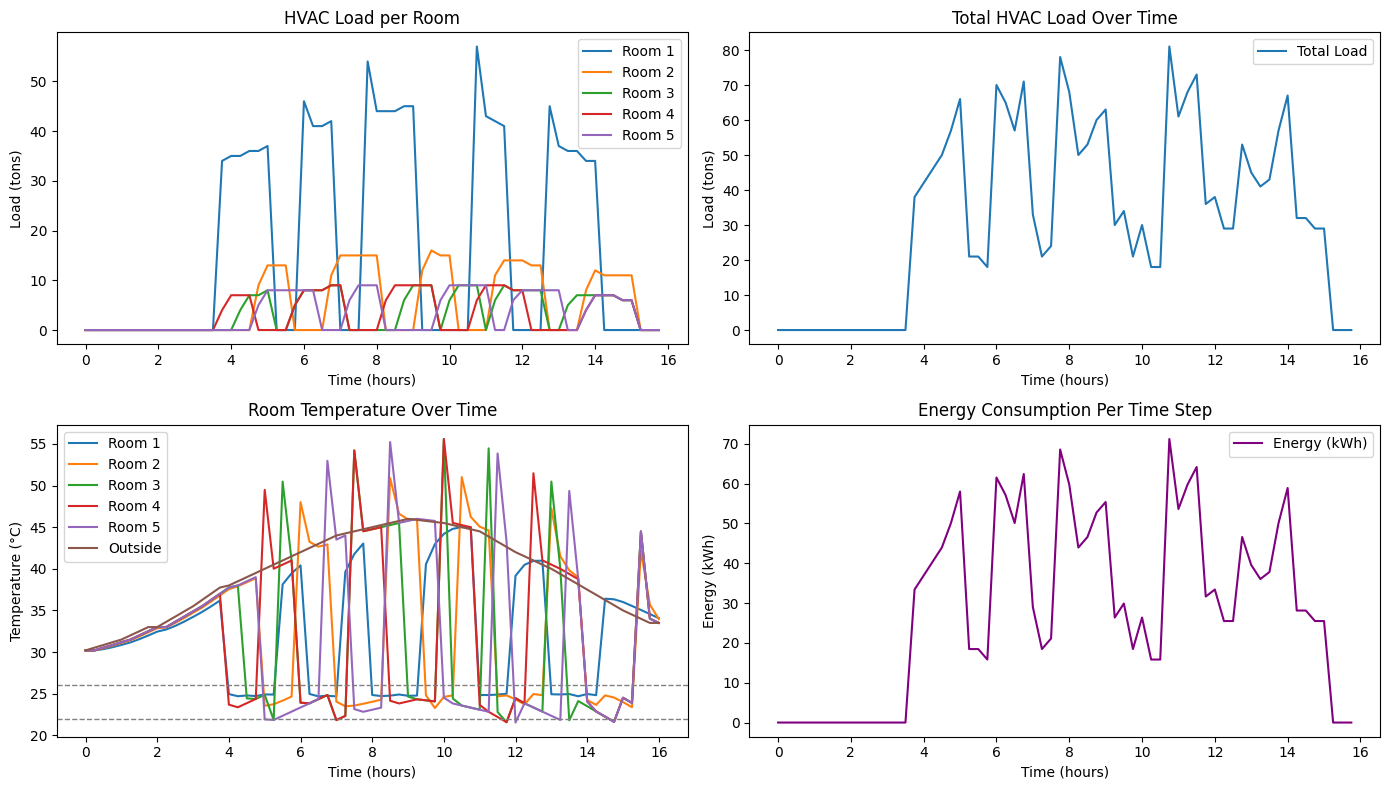

(np.float64(1816.014), np.int64(179))

In [ ]:
L = L_df.to_numpy()
T = T_df.to_numpy()
L=L.transpose()
T=T.transpose()
n_rooms, n_steps = L.shape
time_hours = np.arange(n_steps) * 0.25  # 15-min intervals to hours

# Total HVAC load and energy
total_load_per_step = L.sum(axis=0)
energy_kWh = total_load_per_step * 3516 / 1000 * 0.25  # 1 ton = 3516 W; 15 mins = 0.25 hr
total_energy_kWh = energy_kWh.sum()

# Temperature violations (above 26 during class)
violations = (T[:, :-1] > 26).sum()

# Prepare plots
plt.figure(figsize=(14, 8))

# HVAC Load Plot
plt.subplot(2, 2, 1)
for i in range(n_rooms):
    plt.plot(time_hours, L[i], label=f'Room {i+1}')
plt.title("HVAC Load per Room")
plt.xlabel("Time (hours)")
plt.ylabel("Load (tons)")
plt.legend()

# Total Load and Energy
plt.subplot(2, 2, 2)
plt.plot(time_hours, total_load_per_step, label="Total Load")
plt.title("Total HVAC Load Over Time")
plt.xlabel("Time (hours)")
plt.ylabel("Load (tons)")
plt.legend()

# Temperature Plot
plt.subplot(2, 2, 3)
for i in range(n_rooms):
    plt.plot(np.arange(n_steps + 1) * 0.25, T[i], label=f'Room {i+1}')
plt.plot(np.arange(n_steps + 1) * 0.25, Tinf, label=f'Outside')
plt.axhline(22, color='gray', linestyle='--', linewidth=1)
plt.axhline(26, color='gray', linestyle='--', linewidth=1)
plt.title("Room Temperature Over Time")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()

# Energy over time
plt.subplot(2, 2, 4)
plt.plot(time_hours, energy_kWh, color='purple', label='Energy (kWh)')
plt.title("Energy Consumption Per Time Step")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.legend()

plt.tight_layout()
plt.show()

total_energy_kWh, violations